# Packages

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
%run Neural_Networks.ipynb # Imports Neural Network
plt.style.use('ggplot')

# Set seed for reproducible results

In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Parameters

In [5]:
# Model parameters 
mu = 0.1
sigma = 0.3
S0 = 100
K = 100
r = 0.05
T = 30/365

# Simulation parameters
steps = 30
n_train = 100000
n_test = 10000
dt = T/steps

# Neural Network parameters
epochs = 10
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 3 # Number of hidden layers
n_inputs = 2 # time and logS(t)
n_outputs = 1 # delta1

In [7]:
def BlackScholes(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
callprice = BlackScholes(S0,r,sigma,T,K)
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

In [7]:
xi_train = npr.normal(0,np.sqrt(dt),(n_train,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_train = np.apply_along_axis(np.cumsum,1,xi_train) # Cumulatively adds the realizations along each row
W_train = np.concatenate((np.zeros((n_train,1)),W_train),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_train = np.repeat(drift,n_train,axis=0) # Repeats the row n times
S_train = S0 * np.exp(drift_train + sigma * W_train) # Calculates S(t) at all timesteps and paths

dS_train = np.diff(S_train,1,1) # Calculates the change in S between each time point
time_grid = np.linspace(0,T,steps+1) # Time array

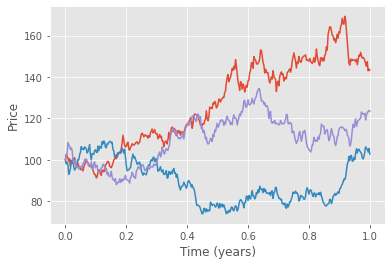

In [14]:
plt.figure(figsize=(6,4))
plt.plot(time_grid,S_train[0],time_grid,S_train[4],time_grid,S_train[2])
plt.xlabel("Time (years)")
plt.ylabel("Price")

plt.show()
#plt.savefig("BSpaths.png",dpi=500,bbox_inches="tight")

In [8]:
input_train = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    logS_train = np.reshape(np.log(S_train[:,i])-np.log(S0),(n_train,1))
    input_train.append(np.concatenate((time_rep,logS_train),1))

In [11]:
def value_pf(y_true,y_pred):
    S = S0
    Vpf = callprice
    B = Vpf - y_pred[:,0]*S
    for i in range(1,steps):
        S += y_true[:,i-1]
        Vpf = y_pred[:,i-1]*S+B*kb.exp(r*dt)
        B = Vpf - y_pred[:,i]*S
    S += y_true[:,-1]
    Vpf = y_pred[:,-1]*S+B*kb.exp(r*dt)
    return Vpf
        
def loss_call(y_true,y_pred):
    return (value_pf(y_true,y_pred) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.))**2

In [12]:
model = FFNN('sigmoid',n_inputs,n_outputs,loss_call, learn_rate,neurons,n_hidden_layers)

In [13]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)
#model.save('BS Call')
#model = tf.keras.models.load_model('BS Call', compile=False)

Epoch 1/10
1000/1000 [==============================] - 61s 55ms/step - loss: 0.5098
Epoch 2/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.3158
Epoch 3/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.3078
Epoch 4/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.3039
Epoch 5/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.3017
Epoch 6/10
1000/1000 [==============================] - 57s 57ms/step - loss: 0.3035
Epoch 7/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.3009
Epoch 8/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.3001
Epoch 9/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.2999
Epoch 10/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.2997


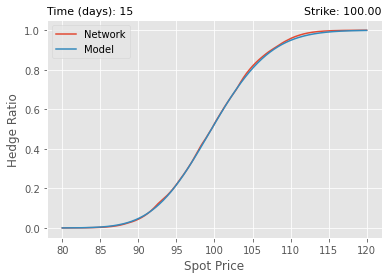

In [44]:
time_plot = 0.5*T
time_plot_days = time_plot*365
input_plot = []
# Number of times to "upscale" the plot. I.e., if steps = 30 and u want 300 points on the plot, use upscale = 10
upscale = 10

delta_NN = np.empty(upscale*steps)
S_grid = np.linspace(0.8*S0,1.2*S0, steps*upscale)

for i in range(upscale):
    input_plot = []
    for j in range(steps):
        z = (time_plot,np.log(S_grid[i*steps+j])-np.log(S0))
        z = np.reshape(z,(1,2))
        input_plot.append(z)
    delta_NN[i*steps:(i+1)*steps] = np.reshape(model.predict(input_plot),(steps,))

    
delta_BS = BlackScholesCallDelta(S_grid,r,sigma,T-time_plot,K)
plt.figure(figsize=(6,4))
line_NN = plt.plot(S_grid,delta_NN,label="Network")
line_BS = plt.plot(S_grid,delta_BS, label="Model")
plt.xlabel("Spot Price")
plt.ylabel("Hedge Ratio")
plt.title(r'Time (days): %1.0f' % time_plot_days, loc='left', fontsize=11)
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.legend()
plt.show()
#plt.savefig("BSdelta4hl200n10e.png", dpi=500,bbox_inches="tight")

# Test

In [9]:
xi_test = npr.normal(0,np.sqrt(dt),(n_test,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_test = np.apply_along_axis(np.cumsum,1,xi_test) # Cumulatively adds the realizations along each row
W_test = np.concatenate((np.zeros((n_test,1)),W_test),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_test = np.repeat(drift,n_test,axis=0) # Repeats the row n times
S_test = S0 * np.exp(drift_test + sigma * W_test) # Calculates S(t) at all timesteps and paths

# S_test = np.load('S_test_BS.npy')
# dS_test = np.diff(S_test,1,1) # Calculates the change in S between each time point

In [10]:
input_test = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    logS_test = np.reshape(np.log(S_test[:,i])-np.log(S0),(n_test,1))
    input_test.append(np.concatenate((time_rep,logS_test),1))

In [45]:
delta_NN_test = model.predict(input_test)
Vpf_NN = callprice
b = Vpf_NN - delta_NN_test[:,0]*S0
for i in range(1,steps):
    Vpf_NN = delta_NN_test[:,i-1]*S_test[:,i]+b*np.exp(r*dt)
    b = Vpf_NN - delta_NN_test[:,i]*S_test[:,i]
Vpf_NN = delta_NN_test[:,-1]*S_test[:,-1]+b*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [46]:
S_grid2 = np.linspace(np.amin(S_test[:,-1]),np.amax(S_test[:,-1]),num=1000)
value_call_grid = np.maximum(S_grid2-K,0)
value_call_true = np.maximum(S_test[:,-1]-K,0)

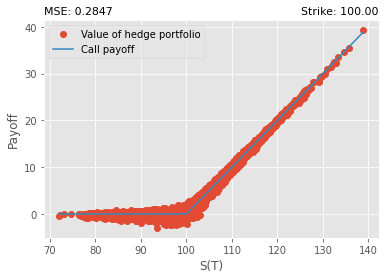

In [47]:
PnL_NN = Vpf_NN - value_call_true
MSE_NN = np.sum(PnL_NN**2)/n_test
plt.figure(figsize=(6,4))
hedge_NN = plt.plot(S_test[:,-1],Vpf_NN, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_NN, loc='left', fontsize=11)
plt.legend(loc='upper left')
plt.show()
#plt.savefig("BS_hedge_NN.png", dpi=500,bbox_inches="tight")

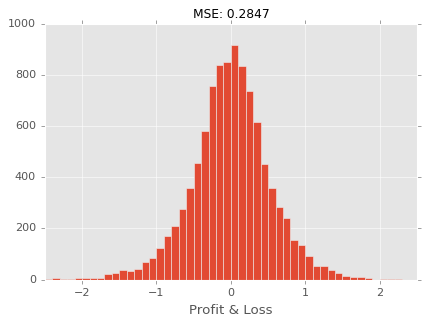

In [48]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_NN, bins=50, range=(-2.5,2.5))
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0, 1000)
plt.show()
#plt.savefig("BS_PnL_call_NN.png", dpi=500,bbox_inches="tight")

# Comparison to hedging using BS delta

In [49]:
delta_BS_test = []
Vpf_m = callprice
a = BlackScholesCallDelta(S0, r, sigma, T, K)
b = Vpf_m - a*S0
for i in range(1,steps):
    Vpf_m = a*S_test[:,i]+b*np.exp(r*dt)
    a = BlackScholesCallDelta(S_test[:,i],r,sigma,T-i*dt,K)
    b = Vpf_m - a*S_test[:,i]
Vpf_m = a*S_test[:,-1]+b*np.exp(r*dt) 

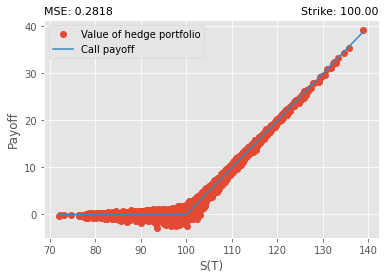

In [50]:
PnL_m = Vpf_m - value_call_true
MSE_m = np.sum(PnL_m**2)/n_test
plt.figure(figsize=(6,4))
hedge_BS = plt.plot(S_test[:,-1],Vpf_m, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_m, loc='left', fontsize=11)
plt.legend(loc='upper left')
plt.show()
#plt.savefig("BS_hedge_m.png", dpi=500,bbox_inches="tight")

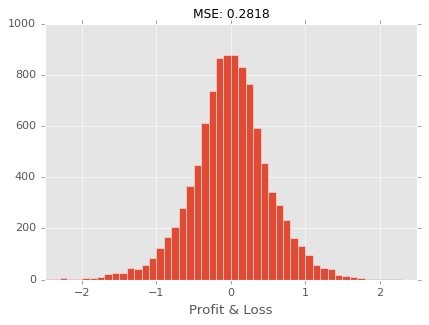

In [51]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_m, bins=50,range=(-2.5,2.5))
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0, 1000)
plt.show()
#plt.savefig("BS_PnL_call_m.png", dpi=500,bbox_inches="tight")